In [1]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from part2 import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, LeaveOneOut

# Load data

animal


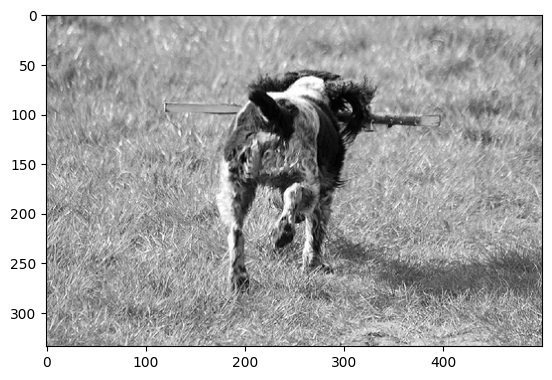

In [2]:
images, labels = load_data("dataset/flickr30k_images", "dataset/labels.csv")
# plt.axis("off")
print(labels[0])
plt.imshow(images[0])

# Process data

In [3]:
labels = [label_to_index(lbl) for lbl in labels]

In [4]:
# augment + embedding
img_size = (512, 512)
image_processor = ImageProcessor("PCA", img_size)
tr_images, tr_labels = image_processor.compute(images, labels, 128)

# shuffle
temp = list(zip(tr_images, tr_labels))
random.shuffle(temp)
tr_images, tr_labels = zip(*temp)

In [5]:
USE_PCA = True

In [6]:
if USE_PCA:
    X = image_processor.vectorize(tr_images, False)
else:
    X = np.ndarray((len(tr_images), img_size[0] * img_size[1]))
    for i in range(len(tr_images)):
        X[i] = tr_images[i].reshape(1, -1)

In [7]:
X.shape

(586, 128)

# Split & scale data

In [8]:
X_train, X_test, y_train, y_test = validation_split(X, tr_labels, 0.2)
print(f"train size: {X_train.shape}")
print(f"test size: {X_test.shape}")

train size: (468, 128)
test size: (118, 128)


In [9]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MyLogisticRegression test on image

In [11]:
model_lr = create_model(ModelType.LogisticRegression)

In [12]:
model_lr.fit(X_train, y_train)

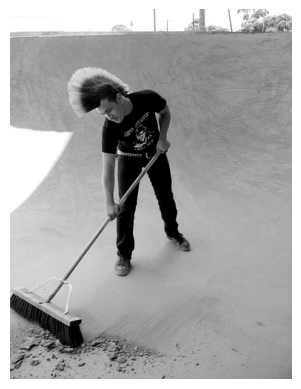

In [13]:
selected_img = images[160]
plt.axis("off")
plt.imshow(selected_img)

In [14]:
if USE_PCA:
    selected_img_processed = image_processor.vectorize([selected_img], True)
else:
    selected_img_processed = image_processor.transform_images([selected_img], None, False)

index_to_label(model_lr.predict(selected_img_processed))

p:\Edu\KMA-ML-HW\HW1\part2.py:115: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


'human'

In [15]:
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

train_score = np.mean(y_train_pred == y_train)
test_score = np.mean(y_test_pred == y_test)

print(train_score)
print(test_score)

0.6346153846153846
0.5508474576271186


# Test All models

## Basic test

In [16]:
def train_and_test_model(model_type: ModelType, X_train, y_train, X_test):
    model = create_model(model_type)

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_test_pred

In [17]:
def print_results(y_train, y_test, y_train_pred, y_test_pred):
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.PuBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [19]:
labels_unique = [index_to_label(ind) for ind in sorted(list(set(labels)))]

### Logistic Regression

In [20]:
y_train_pred_lr, y_test_pred_lr = train_and_test_model(ModelType.LogisticRegression, X_train, y_train, X_test)

Training Accuracy: 0.5726495726495726
Testing Accuracy: 0.4576271186440678
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        71
           1       0.33      0.36      0.35        47

    accuracy                           0.46       118
   macro avg       0.44      0.44      0.44       118
weighted avg       0.47      0.46      0.46       118



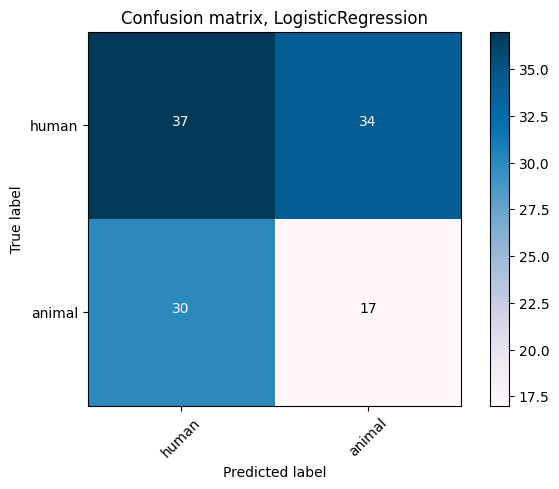

In [21]:
print_results(y_train, y_test, y_train_pred_lr, y_test_pred_lr)

lr_cnf_matrix = confusion_matrix(y_test, np.round(y_test_pred_lr))
plot_confusion_matrix(lr_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, LogisticRegression')

### KNN

In [22]:
y_train_pred_knn, y_test_pred_knn = train_and_test_model(ModelType.KNN, X_train, y_train, X_test)

Training Accuracy: 0.6645299145299145
Testing Accuracy: 0.3983050847457627
              precision    recall  f1-score   support

           0       0.50      0.13      0.20        71
           1       0.38      0.81      0.52        47

    accuracy                           0.40       118
   macro avg       0.44      0.47      0.36       118
weighted avg       0.45      0.40      0.33       118



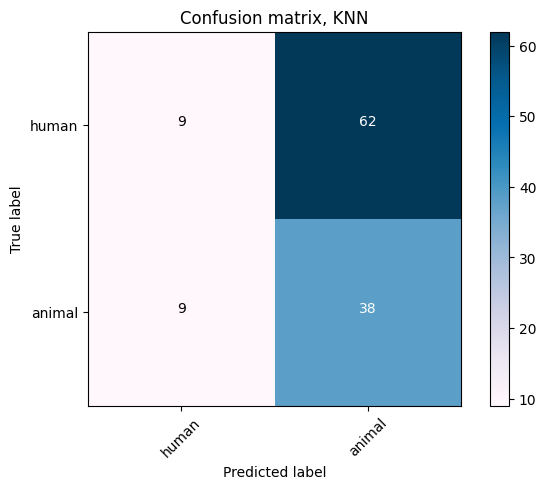

In [23]:
print_results(y_train, y_test, y_train_pred_knn, y_test_pred_knn)

knn_cnf_matrix = confusion_matrix(y_test, np.round(y_test_pred_knn))
plot_confusion_matrix(knn_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, KNN')

### Decision Tree

In [24]:
y_train_pred_dt, y_test_pred_dt = train_and_test_model(ModelType.DecisionTree, X_train, y_train, X_test)

Training Accuracy: 1.0
Testing Accuracy: 0.4830508474576271
              precision    recall  f1-score   support

           0       0.58      0.52      0.55        71
           1       0.37      0.43      0.40        47

    accuracy                           0.48       118
   macro avg       0.47      0.47      0.47       118
weighted avg       0.50      0.48      0.49       118



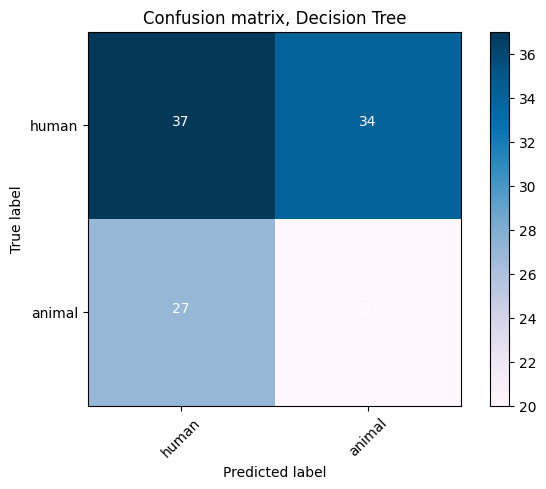

In [25]:
print_results(y_train, y_test, y_train_pred_dt, y_test_pred_dt)

dt_cnf_matrix = confusion_matrix(y_test, np.round(y_test_pred_dt))
plot_confusion_matrix(dt_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, Decision Tree')

## KNN Train, Validate, Test

In [26]:
X_val, X_test2, y_val, y_test2 = validation_split(X_test, y_test, 0.5)

In [27]:
n_neighbors_list = [3, 5, 7, 9]

best_n_neighbors = None
best_val_accuracy = 0

for k in n_neighbors_list:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"KNN with n_neighbors={k}, Validation Accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_n_neighbors = k

model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test2)

KNN with n_neighbors=3, Validation Accuracy: 0.4067796610169492
KNN with n_neighbors=5, Validation Accuracy: 0.4067796610169492
KNN with n_neighbors=7, Validation Accuracy: 0.3898305084745763
KNN with n_neighbors=9, Validation Accuracy: 0.3559322033898305


Training Accuracy: 0.6645299145299145
Testing Accuracy: 0.3898305084745763
              precision    recall  f1-score   support

           0       0.44      0.11      0.18        35
           1       0.38      0.79      0.51        24

    accuracy                           0.39        59
   macro avg       0.41      0.45      0.35        59
weighted avg       0.42      0.39      0.32        59



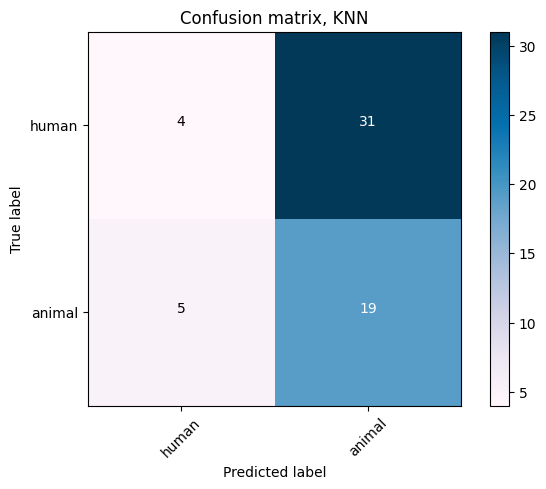

In [28]:
print_results(y_train, y_test2, y_train_pred, y_test_pred)

knn_cnf_matrix = confusion_matrix(y_test2, np.round(y_test_pred))
plot_confusion_matrix(knn_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, KNN')

## Decision Tree Cross Validation

In [29]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [d for d in range(5, 51, 5)],
                  'min_samples_split': [s/10 for s in range(1, 9)],
                  'min_samples_leaf': [.05] + [s/10 for s in range(1, 6)],
                  'max_features': [s/10 for s in range(1, 9)],
                  'random_state': [0, 25, 50],
                  'max_leaf_nodes': [None] + [n for n in range(100, 1001, 100)],
                 }

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
model_dtc = DecisionTreeClassifier(**grid_search.best_params_)

Best score: 0.6089647610405324
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.3, 'max_leaf_nodes': 100, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'random_state': 0}


Cross-validation scores: [0.57446809 0.59574468 0.68085106 0.4893617  0.55319149 0.70212766
 0.59574468 0.70212766 0.65217391 0.65217391]
Mean CV accuracy: 0.6197964847363553
Standard deviation of CV accuracy: 0.0663642993880087
              precision    recall  f1-score   support

           0       0.63      0.83      0.72        71
           1       0.52      0.28      0.36        47

    accuracy                           0.61       118
   macro avg       0.58      0.55      0.54       118
weighted avg       0.59      0.61      0.58       118



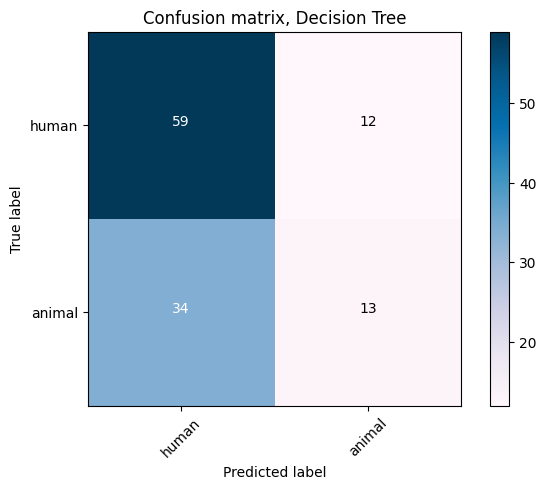

In [30]:
model_dtc.fit(X_train, y_train)
y_train_pred = model_dtc.predict(X_train)
y_test_pred = model_dtc.predict(X_test)

cv_scores = cross_val_score(model_dtc, X_train, y_train, cv=folds, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation of CV accuracy: {np.std(cv_scores)}")

print(classification_report(y_test, y_test_pred))

dt_cnf_matrix = confusion_matrix(y_test, np.round(y_test_pred))
plot_confusion_matrix(dt_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, Decision Tree')

## Decision Tree Leave One Out

In [31]:
folds = LeaveOneOut()
model = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [d for d in range(5, 21, 5)],
                  #'min_samples_split': [s/10 for s in range(2, 9, 2)],
                  #'min_samples_leaf': [s for s in range(3, 5)],
                #   'max_features': [s for s in range(6, 9)],
                  'random_state': [42],
                  #'max_leaf_nodes': [None] + [n for n in range(100, 901, 200)],
                 }

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
model_dtc = DecisionTreeClassifier(**grid_search.best_params_)

Best score: 0.5170940170940171
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'random_state': 42}


Mean LOOCV accuracy: 0.5170940170940171
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        71
           1       0.37      0.38      0.38        47

    accuracy                           0.49       118
   macro avg       0.47      0.47      0.47       118
weighted avg       0.50      0.49      0.49       118



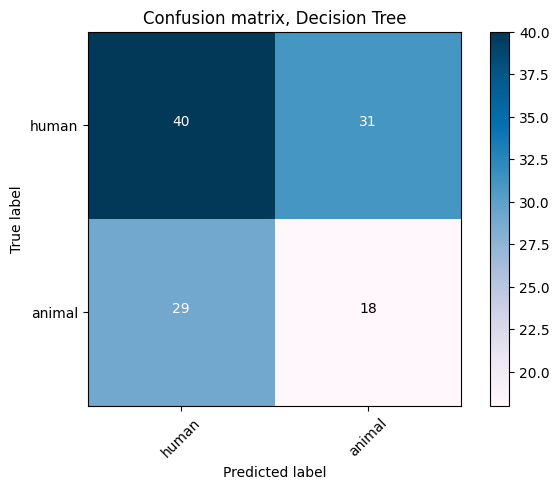

In [33]:
model_dtc.fit(X_train, y_train)
y_train_pred = model_dtc.predict(X_train)
y_test_pred = model_dtc.predict(X_test)

cv_scores_loo = cross_val_score(model_dtc, X_train, y_train, cv=folds, scoring='accuracy')

# print(f"LOOCV scores: {cv_scores_loo}")
print(f"Mean LOOCV accuracy: {np.mean(cv_scores_loo)}")

print(classification_report(y_test, y_test_pred))

dt_cnf_matrix = confusion_matrix(y_test, np.round(y_test_pred))
plot_confusion_matrix(dt_cnf_matrix, classes=labels_unique,
                      title='Confusion matrix, Decision Tree')